# Swiss rental prices

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

## Full Dataset

In [46]:
# Data from: https://datenportal.info/wohnungsmarkt/wohnungsmieten/

rents_df = pd.read_csv("mietinserate_v1.csv", sep=";")
rents_df.head()

,ID,Jahr,Quartal,Wohnungstyp,Zimmer,Fläche,Mietpreis_Brutto,Quadratmeterpreis_Brutto,Adresse,PLZ_Ort,Bezugsdatum,GKODE,GKODN,"KT,"
0,1,2019,4,Wohnung,4.5,NaN,1850,NaN,Aachstrasse 13,9327 Tübach,NaN,2752059.0,1261281.0,"SG,"
1,2,2019,2,Wohnung,3.5,75.0,1180,16.0,Aachstrasse 29,8586 Erlen,NaN,2734483.0,1268102.0,"TG,"
2,3,2019,4,Maisonettewohnung,3.5,NaN,1400,NaN,Aachstrasse 31b,8586 Erlen,NaN,2734427.0,1268073.0,"TG,"
3,4,2019,2,Wohnung,4.5,NaN,1750,NaN,Aachstrasse 5,9327 Tübach,NaN,2751994.0,1261267.0,"SG,"
4,5,2019,2,Wohnung,5.5,NaN,2450,NaN,Aachstrasse 5,9327 Tübach,NaN,2751994.0,1261267.0,"SG,"


### Test/Train Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

### Basic Cleaning

In [3]:
rents_df["Ort"] = rents_df["PLZ_Ort"].str.split(" ").str[1]
rents_df["PLZ"] = rents_df["PLZ_Ort"].str.split(" ").str[0].astype("int")
rents_df["KT,"] = rents_df["KT,"].str.replace(",", "")
rents_df.rename(columns={"KT,": "KT"}, inplace=True)
rents_df = rents_df.drop(columns=["ID"])

rents_df.head()

,Jahr,Quartal,Wohnungstyp,Zimmer,Fläche,Mietpreis_Brutto,Quadratmeterpreis_Brutto,Adresse,PLZ_Ort,Bezugsdatum,GKODE,GKODN,KT,Ort,PLZ
0,2019,4,Wohnung,4.5,NaN,1850,NaN,Aachstrasse 13,9327 Tübach,NaN,2752059.0,1261281.0,SG,Tübach,9327
1,2019,2,Wohnung,3.5,75.0,1180,16.0,Aachstrasse 29,8586 Erlen,NaN,2734483.0,1268102.0,TG,Erlen,8586
2,2019,4,Maisonettewohnung,3.5,NaN,1400,NaN,Aachstrasse 31b,8586 Erlen,NaN,2734427.0,1268073.0,TG,Erlen,8586
3,2019,2,Wohnung,4.5,NaN,1750,NaN,Aachstrasse 5,9327 Tübach,NaN,2751994.0,1261267.0,SG,Tübach,9327
4,2019,2,Wohnung,5.5,NaN,2450,NaN,Aachstrasse 5,9327 Tübach,NaN,2751994.0,1261267.0,SG,Tübach,9327


### Converting Coordinates

In [42]:
long = []
lat = []

for i in range(len(rents_df)):    
    r = requests.get(f'http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting={rents_df.loc[i, "GKODE"]}&northing={rents_df.loc[i, "GKODN"]}&format=json')
    coord_dict = json.loads(r.content)
    long.append(coord_dict["easting"])
    lat.append(coord_dict["northing"])


In [43]:
rents_df["long"] = long
rents_df["lat"] = lat

In [44]:
rents_df.to_csv("rents_with_coords.csv", index=False)

In [1]:
rents_df_coords = pd.read_csv("rents_with_coords.csv")
rents_df_coords

NameError: name 'pd' is not defined

### Exploration

In [4]:
rents_df.dtypes

Jahr                          int64
Quartal                       int64
Wohnungstyp                  object
Zimmer                      float64
Fläche                      float64
Mietpreis_Brutto              int64
Quadratmeterpreis_Brutto    float64
Adresse                      object
PLZ_Ort                      object
Bezugsdatum                  object
GKODE                       float64
GKODN                       float64
KT,                          object
Ort                          object
PLZ                           int64
dtype: object

In [46]:
rents_df["KT"].value_counts()

SG    8068
ZH    6293
BE    5998
AG    5319
LU    3640
TG    3568
BL    2485
GR    2380
TI    2375
VD    2256
SO    1987
FR    1766
NE    1553
BS    1521
SZ    1458
VS    1261
SH    1156
AR     931
JU     478
GE     474
GL     432
ZG     390
NW     345
UR     283
OW     192
AI     168
Name: KT, dtype: int64

## Subset: Zurich

In [5]:
rents_df_zurich = rents_df[rents_df["Ort"]=="Zürich"].dropna().reset_index(drop=True)

In [6]:
rents_df_zurich.to_csv("zurich_rents_df.csv", index=False)

In [7]:
rents_df_zurich.columns

Index(['Jahr', 'Quartal', 'Wohnungstyp', 'Zimmer', 'Fläche',
       'Mietpreis_Brutto', 'Quadratmeterpreis_Brutto', 'Adresse', 'PLZ_Ort',
       'Bezugsdatum', 'GKODE', 'GKODN', 'KT,', 'Ort', 'PLZ'],
      dtype='object')

### Exploration

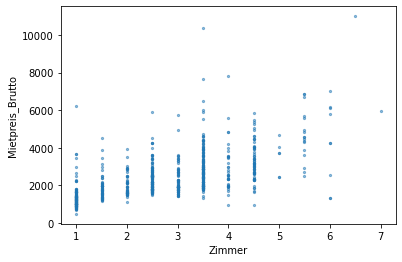

In [8]:
%matplotlib inline

size = 5
rents_df_zurich.plot.scatter(x='Zimmer', y='Mietpreis_Brutto', s=size, alpha=.5);

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(rents_df_zurich[['Zimmer']].values, # X
                                                    rents_df_zurich['Mietpreis_Brutto'].values, # y
                                                    test_size=0.2, # %age of test split
                                                    random_state=17) # ensure reproducibility

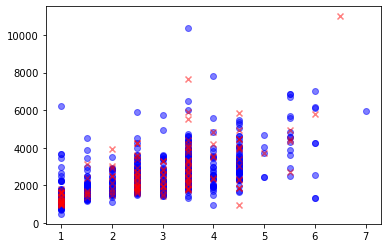

In [10]:
plt.scatter(X_train, y_train, color = 'blue', marker='o', alpha=.5)
plt.scatter(X_test, y_test, color = 'red', marker='x', alpha=.5);

### Linear Regression

#### Check Results

In [11]:
from sklearn.linear_model import LinearRegression

# instantiating the model
regr = LinearRegression()

# train the model on the training data
regr.fit(X_train, y_train)

# predict on the unseen test data
pred = regr.predict(X_test)

In [12]:
pred[:5]

array([2864.13412081, 2585.52860188, 3142.73963975, 1471.10652614,
       4535.76723443])

In [13]:
y_test[:5]

array([ 3178,  3318,  2320,  1250, 11000])

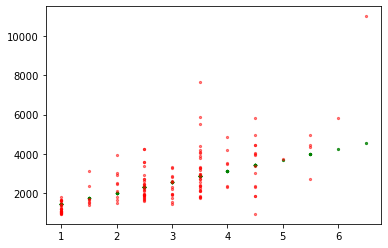

In [14]:
plt.scatter(X_test, pred, color = 'green', s=size, alpha=.8)
plt.scatter(X_test, y_test, color = 'red', s=size, alpha=.5);

In [15]:
from sklearn import metrics

print('MAE', metrics.mean_absolute_error(y_test, pred))
print('MSE', metrics.mean_squared_error(y_test, pred))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('R2 Score', metrics.r2_score(y_test, pred))

MAE 726.230142793783
MSE 1212618.9859274076
RMSE 1101.1898046782887
R2 Score 0.3985290765324626


In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regr, X_train, y_train, cv=10, scoring='r2')
scores

array([0.05362692, 0.33853907, 0.41740458, 0.31981147, 0.25741406,
       0.49244302, 0.15240413, 0.42374996, 0.42859127, 0.41170007])

In [17]:
np.mean(scores)

0.32956845729522277

In [18]:
def plot_regression(X_train, X_test, y_train, y_test, predictions, plot_title):
    
    zipped = sorted(zip(X_test, predictions))

    #extract variables from the list otherwise we cannot plot 
    X_test_sorted, y_pred_sorted = zip(*zipped)
    plt.scatter(X_train, y_train, color = 'blue', label='Train')
    plt.scatter(X_test, y_test, color = 'red', label='Test')
    plt.plot(X_test_sorted, y_pred_sorted, color = 'black', label='Preds')
    plt.title(plot_title)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend();

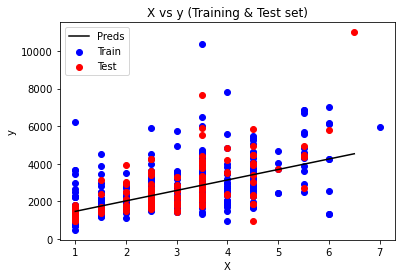

In [19]:
plot_regression(
    X_train,
    X_test,
    y_train,
    y_test,
    pred,
    "X vs y (Training & Test set)",
)

#### Pipeline

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(rents_df_zurich.select_dtypes(["int64", "float64"]).drop(columns=["Mietpreis_Brutto", "Quadratmeterpreis_Brutto"]).values,
                                                    rents_df_zurich['Mietpreis_Brutto'].values, 
                                                    test_size=0.2, 
                                                    random_state=17)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipeline3 = Pipeline(steps = [("standard_scale", StandardScaler()),
                              ("modeling", LinearRegression())])

pipeline3

Pipeline(steps=[('standard_scale', StandardScaler()),
                ('modeling', LinearRegression())])

In [22]:
scores = cross_val_score(pipeline3, X_train, y_train, cv=5, scoring='r2')
scores

array([0.67591077, 0.61208386, 0.63382895, 0.59608188, 0.55872714])

In [23]:
np.mean(scores)

0.6153265198430068

In [24]:
pipeline3.fit(X_train, y_train)

pred6 = pipeline3.predict(X_test)

In [25]:
y_test[:5], pred6[:5]

(array([ 3178,  3318,  2320,  1250, 11000]),
 array([2930.25144538, 2966.30607214, 2606.45286674, 1588.73520146,
        5282.30619116]))

In [26]:
print('MAE', metrics.mean_absolute_error(y_test, pred6))
print('MSE', metrics.mean_squared_error(y_test, pred6))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, pred6)))
print('R2 Score', metrics.r2_score(y_test, pred6))

MAE 548.9214232240266
MSE 771969.8374254995
RMSE 878.6181408470345
R2 Score 0.617095380829543
